# Linear Autoregression
<hr style="border:2px solid black">

**Autoregressive Model**
>- time series model that uses observations from previous time steps as input to a regression equation
>- predicts the value at the next time step
>- very simple idea that can result in accurate forecasts on a range of time series problems

<hr style="border:2px solid black">

## 1. Getting Started

### 1.1 Load Packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.linear_model import LinearRegression

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

### 1.2 User-Defined Functions

**quartile coefficient of dispersion**

In [2]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

### 1.3 Load Data

In [3]:
df = pd.read_csv(
    "../data/milk_remainder.csv"
).set_index('date')

df.head()

,remainder
date,
1962-01-01,8.028350
1962-02-01,16.345584
1962-03-01,1.970510
1962-04-01,0.595436
1962-05-01,8.528055


### 1.4 Explore Data

**plot remainder**

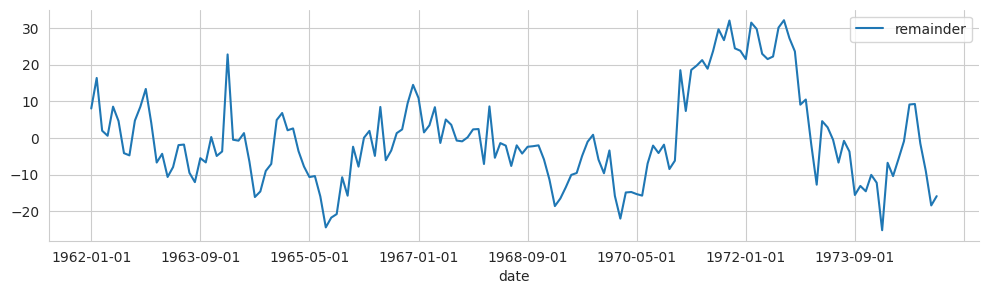

In [4]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['remainder'].plot(legend=True)
sns.despine()

**check homoscedasticity**

In [5]:
# quartile coefficient of dispersion

qcd_variance(df['remainder'])

quartile coefficient of dispersion: 0.433963


<hr style="border:2px solid black">

## 2. Time-Lagged Features

>***A lag is an interval of time between two related observations***

**create lagged features**

In [6]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [7]:
# maximum number of lags to consider
p = 3

In [8]:
# create lag columns in dataframe
df = create_lagged_features(df, p)

In [9]:
df.head()

,remainder,lag_1,lag_2,lag_3
date,,,,
1962-01-01,8.028350,NaN,NaN,NaN
1962-02-01,16.345584,8.028350,NaN,NaN
1962-03-01,1.970510,16.345584,8.028350,NaN
1962-04-01,0.595436,1.970510,16.345584,8.028350
1962-05-01,8.528055,0.595436,1.970510,16.345584


In [10]:
df.tail()

,remainder,lag_1,lag_2,lag_3
date,,,,
1974-08-01,9.254258,9.109953,-0.880505,-5.717117
1974-09-01,-1.524515,9.254258,9.109953,-0.880505
1974-10-01,-8.995595,-1.524515,9.254258,9.109953
1974-11-01,-18.389752,-8.995595,-1.524515,9.254258
1974-12-01,-15.860832,-18.389752,-8.995595,-1.524515


### 2.1 Autocorrelation Scatterplot

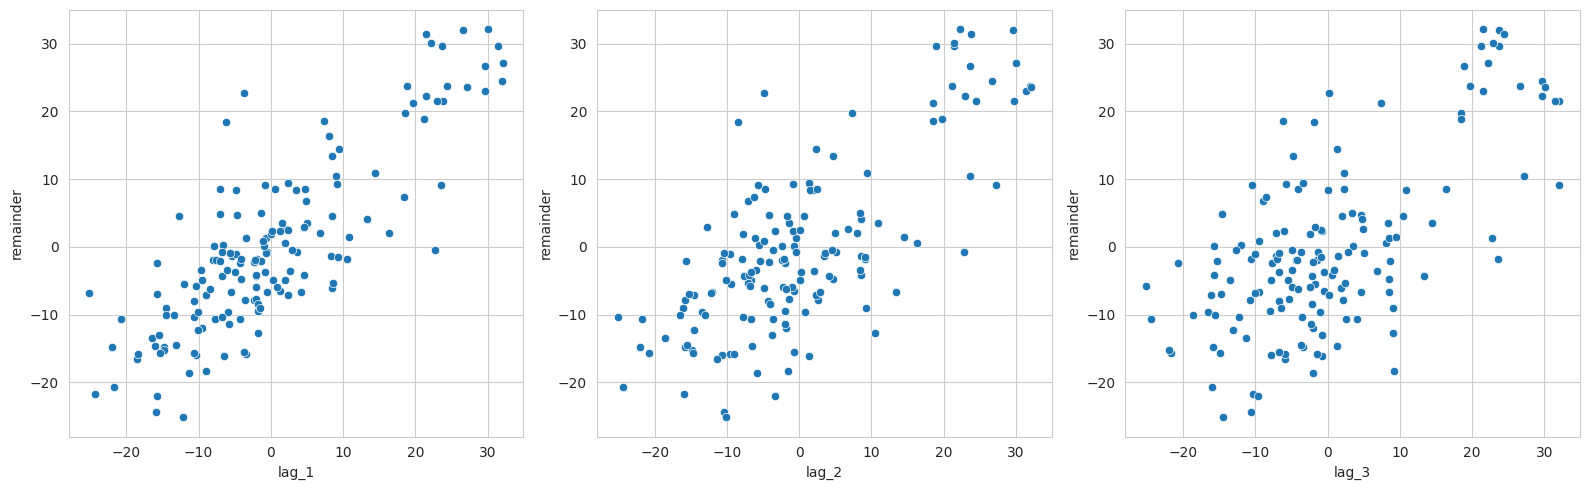

In [11]:
import matplotlib.gridspec as gridspec

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(
        x=df[lag_columns[i]],
        y=df['remainder'],
        ax=axes[i]
    )
    
plt.tight_layout()

### 2.2 Autocorrelation Heatmap

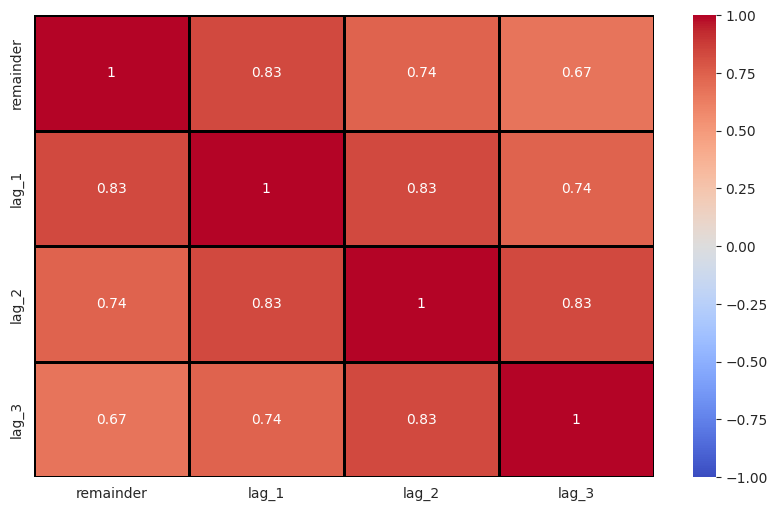

In [12]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

**Observation**
- There is fairly strong correlation between data and time-lagged features
- A positive remainder this month would hint towards a positive remainder next month. If this month more milk than expected is produced, then the amount of milk produced next month is likely to be higher than predicted by trend and seasonality.

<hr style="border:2px solid black">

## 3. Autoregressive (AR) Model

In an autoregressive model, one models the present value of a variable by looking at the past values of the same variable:

>$$
y_{t} = c + \sum_{j=1}^{p}\phi_{j}y_{t-j} + \epsilon_t,
$$ 

where we have an AR($p$) model, with
>- $t$ the current timestep
>- $c$ the *bias/intercept* 
>- $\phi_j$’s the *weights* of the model
>- $\epsilon$ the *error*; some *independent and identically distributed (iid) noise*, e.g., Gaussian noise
>- $p$ the number of lags to use, called the *order* of the model, is a hyperparameter to be chosen

For the noise, it holds that (recall assumptions of linear regression)
>- $E(\epsilon_t)=E(\epsilon)=0$: $~~~~~~~~~~~~~~~~$time-invariant expectation value of zero
>- $V(\epsilon_t)=V(\epsilon)=\text{constant}$: $~~~~$time-invariant variance

### Examples

**AR(1) Model**: $~~~~~\hat{y_{t}} = c + \phi_1 \times y_{t-1}$
- The value at timestep $t$ as a linear function of the value at $t-1$

**AR(2) Model**: $~~~~~\hat{y_{t}} = c + \phi_1 \times y_{t-1} + \phi_2 \times y_{t-2}$
- The value at timestep $t$ as a linear function of the values at $t-1$ and $t-2$

### Modeling the Remainder

In [13]:
# Drop missing values

df.dropna(inplace=True)
df.head()

,remainder,lag_1,lag_2,lag_3
date,,,,
1962-04-01,0.595436,1.970510,16.345584,8.028350
1962-05-01,8.528055,0.595436,1.970510,16.345584
1962-06-01,4.614519,8.528055,0.595436,1.970510
1962-07-01,-4.145170,4.614519,8.528055,0.595436
1962-08-01,-4.751013,-4.145170,4.614519,8.528055


In [14]:
# feature and target for autoregression model

X_remainder = df.drop('remainder',axis=1)
y_remainder = df['remainder']

In [15]:
# model for remainder

ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [16]:
# prediction

df['ar_predictions'] = ar_model.predict(X_remainder)

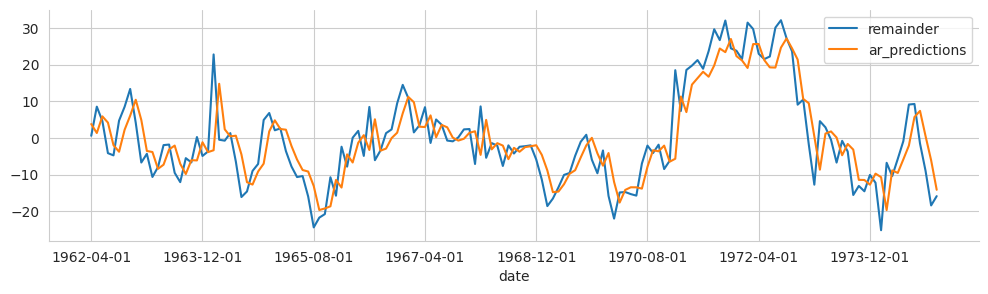

In [17]:
# Plot original remainder and prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','ar_predictions']].plot(legend=True)
sns.despine()

**Q: How many lags should we use for the autoregressive model?**

<hr style="border:2px solid black">

## 4. (Partial) Autocorrelation

**Autocorrelation**

>Correlation between observation at the current time spot and the observations at a previous time spot
>
>$$
corr(y_t,y_{t-h})~=~\frac{cov(y_t,y_{t-h})}{\sigma(y_t)\cdot\sigma(y_{t-h})}
$$
>
>Autocorrelation: calculated between the variable and itself at previous time steps

**Partial Autocorrelation**

>Autcorrelation between observations at two time spots, not accounted for by intermediate lags:
>
>$$
\delta_h~=~corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1}) ~=~corr(y_t-\hat{y}_t, y_{t-h}-\hat{y}_{t-h})$$
>
>They are essentially the coefficients in an autoregression model

**(Partial) Autocorrelation Function (ACF & PACF)**

In [18]:
# function provided by statsmodels

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 4.1 Check Remainder

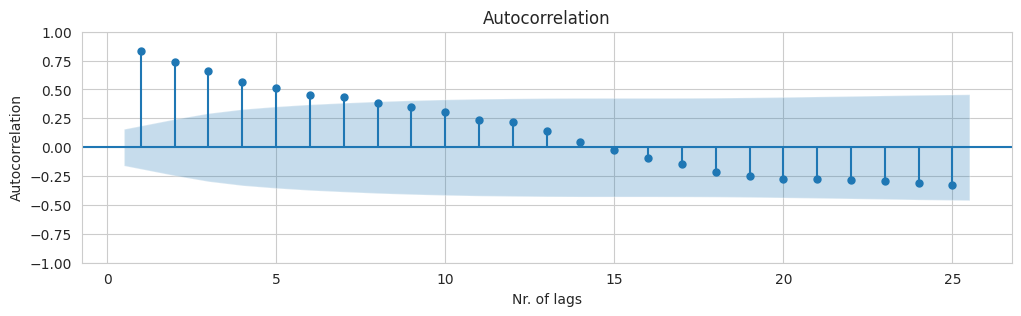

In [19]:
# plot autocorrelation function

plt.rcParams["figure.dpi"] = 100
plot_acf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

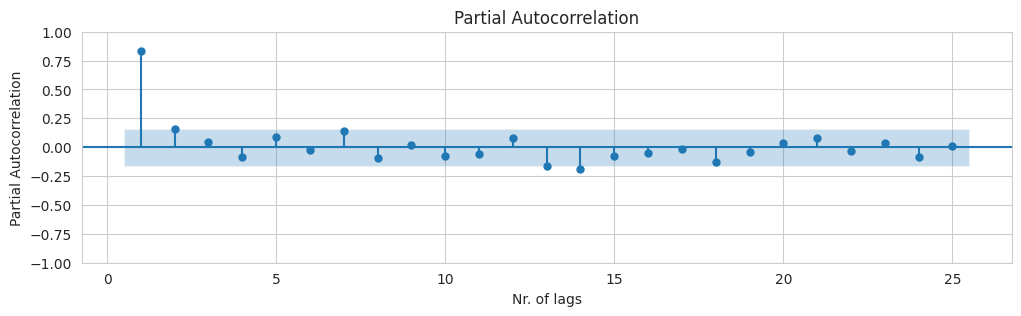

In [20]:
# plot partial autocorrelation function

plot_pacf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

***We choose all lags until the first partial autocorrelation value ends up within the confidence interval***

### 4.2 Check Residual

In [21]:
# residual noise

df['residuals_ar'] = df['remainder'] - df['ar_predictions']

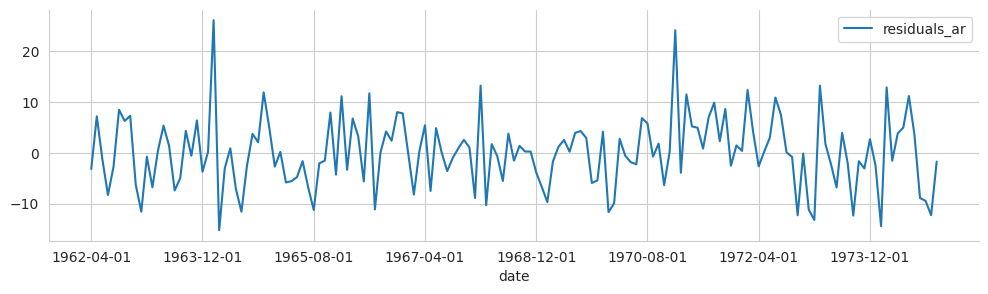

In [22]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['residuals_ar'].plot(legend=True)
sns.despine()

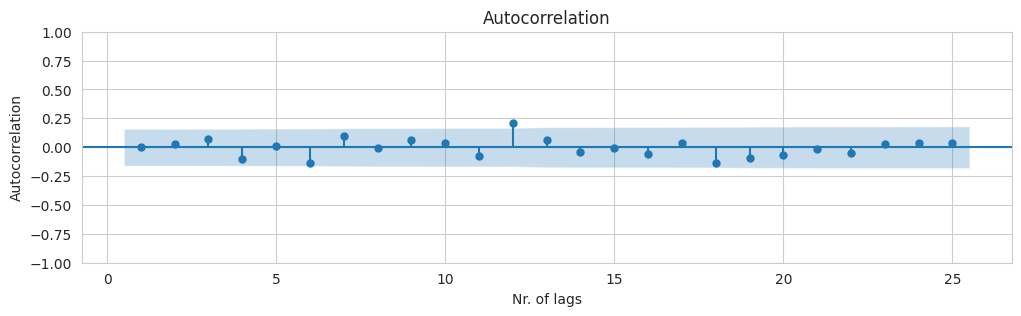

In [23]:
# plot autocorrelation function

plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

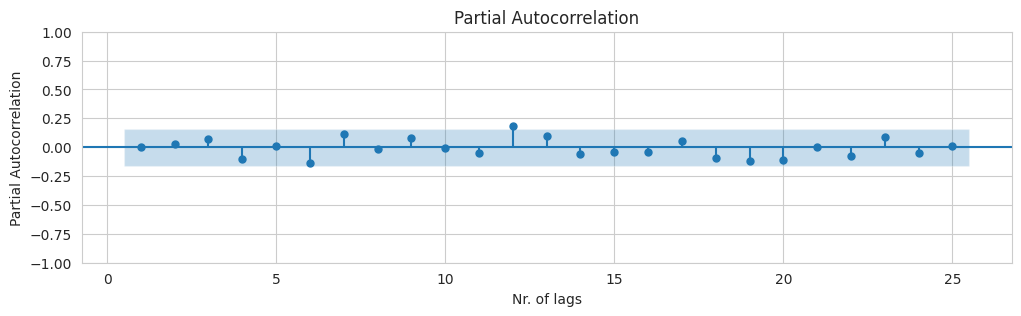

In [24]:
# plot partial autocorrelation function

plot_pacf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

<hr style="border:2px solid black">

## 5. Additional Topics

### 5.1 Assumtions of AR Model

**Linearity**
- linear relationship between observation and time-lagged features

**Weak Stationarity**
- The statistical properties of the series do not depend on the time at which the series is observed. In other words, a time series is stationary if the expectation, variance and autocorrelations do not change over time:

$$
E(y_t)=E(y)=\mu,
\qquad V(y_t)=V(y)=\sigma²,
\qquad corr(y_t,y_{t-h})=c_h
$$

- In the long run, a stationary time series is not predictible

**Weak Dependence**
- Autocorrelation becomes smaller and smaller as lag becomes larger

### 5.2 Backshift Operator *B*

>$By_t=y_{t-1},\qquad B²y_t=By_{t-1}=y_{t-2},\quad\cdots\quad B^py_t=y_{t-p}$

**AR(*p*) Model**
> $$
y_{t} = c + \sum_{j=1}^{p}\phi_{j}B^{\,j}y_t + \epsilon_t,\qquad or \quad
\left(1-\sum_{j=1}^{p}\phi_{j}B^{\,j}\right)y_t = c + \epsilon_t,
$$

Concisely,
> $$
\phi_{p}(B)\,y_t = c + \epsilon_t,\qquad where \quad 
\phi_{p}(B)\equiv 1-\sum_{j=1}^{p}\phi_{j}B^{\,j}
$$

<hr style="border:2px solid black">

## References

- Forecasting: Principles and Practice, R. J. Hyndman & G. Athanasopoulos,
[OTexts Free Online Book](https://otexts.com/fpp3/)
- [Time Series Talk : Autoregressive Model](https://www.youtube.com/watch?v=5-2C4eO4cPQ&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=9)
- [Time Series Talk : Autocorrelation and Partial Autocorrelation](https://www.youtube.com/watch?v=DeORzP0go5I&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=2)